# W207.6 Final Project - Predicting Cancer Type from Tumor Mutations
## Notebook 5 - Classification Diagnostics
### Tony Di Sera, Vijay Singh, Rajiv Nair, Jeremey Fraenkel



In this notebook, we will try to dig into a particular classifier to understand it behavior and get some insights about the kind of mistakes that this classifier is making with our data.

In [0]:
import pandas as pd
import urllib.request
import numpy as np
import glob
import os
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn import preprocessing
from sklearn import metrics
from sklearn import utils
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [0]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [5]:
# This downloads a dictionary file
dictionary_filename = "./raw/tcga_dictionaries.txt"
if os.path.isfile(dictionary_filename):
    print("Skipping download, as file %s is present" %(dictionary_filename))
else:
    print('Downloading dictionary file...')
    url = 'https://w207-final-project.s3.amazonaws.com/raw/tcga_dictionaries.txt'  
    urllib.request.urlretrieve(url, dictionary_filename)  
print("done.")

# This loads the data dictionary to will convert
# the tumor_sample_barcode into a cancer_type
# and provide full names for the cancer types
tcga_dict = open("./raw/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 4:
        tissue_source_site = eval(line)            
    elif dict_name_index == 5:
        code_to_disease = eval(line)
    elif dict_name_index == 6:
        disease_to_code = eval(line)

Skipping download, as file ./raw/tcga_dictionaries.txt is present
done.


In [0]:
def getDataAndLabels(name, features, label_encoder):
    labels_string = features.cancer_type
   
    labels        = label_encoder.fit_transform(labels_string)

    # Get rid of the cancer type and patient_barcode columns 
    data = features[features.columns[3:]]

    return {'name': name, 'feature_size': data.shape[1],
            'data': data, 'labels': labels , 'label_encoder': label_encoder }

## Model Details ##

Based on a full matrix run of all classifiers on all datasets, we find that LogisticRegression gives the best results with the file l1reg_c10, which is a dataset obtained by doing L1 regularization with a C value of **10**. For this dataset, we determined a C value of **0.1** using GridSearchCV for the actual classification task. Using this value of the hyper-parameter, our results were:


**Accuracy:**  0.555012225	
**Precision:** 0.603711834	
**Recall:**    0.555012225	
**F1 Score:**  0.531877786	
**Run Time:**  97.03445305 seconds

We will analyze the results of this classifier in this section.

In [0]:
# get the data and labels from the dataset being analyzed
# returns an encoder fit to data, if one is not passed in
def get_data_labels(file_name, le=None):  
    data = pd.read_csv(file_name)
    data = data.drop(columns=["Unnamed: 0", "case_id"])
    if le is None:
        le = preprocessing.LabelEncoder()
        labels = le.fit_transform(data.cancer_type)
    else:
        labels = le.transform(data.cancer_type)
    data = data.drop(columns=["cancer_type"])
    return data, labels, le

In [0]:
def run_classifier(train_data, train_labels, test_data):
    # setup and run the LR classifier according to specification
    cfr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                             C=0.01, solver="lbfgs", 
                             multi_class="multinomial", random_state=42)
    cfr.fit(train_data, train_labels)
    predict = cfr.predict(test_data)
    return cfr, predict

In [0]:
def analyze_classifier(test_labels, predict_labels, encoder):
    print("\nClassification Report: \n")
    print(metrics.classification_report(test_labels, predict_labels))
    conf_matrix = metrics.confusion_matrix(test_labels, predict_labels)
    
    print("Confusion Matrix Analysis: \n")
    for i in range(conf_matrix.shape[0]):
        conf_matrix[i][i] = 0
        cases = sum(conf_matrix[i])
        m = np.argmax(conf_matrix[i])
        w = conf_matrix[i][m]
        print("Cancer: %s [%d cases], \tmisclassifed as %s [%d cases]"
          %(encoder.classes_[i], cases, encoder.classes_[m], w))

In [0]:
# load the training data and labels into memory
train_data, train_labels, encoder = get_data_labels("./data/features_l1reg_c10.train.csv")

In [11]:
encoder.classes_

array(['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA',
       'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC',
       'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ',
       'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS',
       'UVM'], dtype=object)

Let's examine the relative frequencies of the different cancer types in our training data. We use a histogram to examine this data visually.

(array([ 67., 322., 809., 231.,  24., 322.,  31., 155., 317., 418.,  51.,
        305., 222., 111., 404., 285., 462., 379.,  67., 330., 141., 142.,
        406., 120., 195., 367., 365., 110., 370., 101., 444., 106.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32.]),
 <a list of 32 Patch objects>)

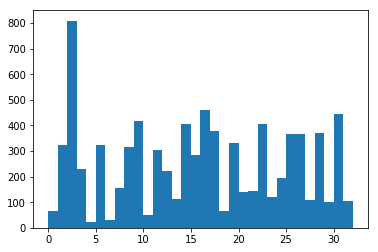

In [12]:
plt.hist(train_labels, bins=32)

It is clear from this, that some cancers have a disproportionate amount of representation in our dataset. 

In [0]:
# load the test data and labels into memory
test_data, test_labels, _ = get_data_labels("./data/features_l1reg_c10.test.csv", encoder)

In [0]:
# setup and run the LR classifier according to specification
lr_cfr, predict_labels = run_classifier(train_data, train_labels, test_data)

## Analysis of Local Results ##

We were not able to replicate the results of the full-matrix search, but we get an overall weighted average score of 0.52. More importantly, we see that some of the cancers such as **ACC** do very poorly. Let's look at where the classifier is making mistakes.

In [15]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(metrics.confusion_matrix(test_labels, predict_labels))

[[  0   0  22   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   1   0   0   0   0   0   0   0   1   0   0]
 [  0  45  27   0   0   0   0   0   1   8   0   0   0   0   0   1   2   0
    0   1   0   0   1   0   0   1   2   0   0   0   0   0   0]
 [  0   4 197   0   0   0   0   0   0   1   0   0   0   0   1   0   0   1
    0   2   0   0   2   0   0   0   0   0   2   0   1   0   0]
 [  0   1  47   2   0   1   0   0   0   2   0   0   0   0   0   0   0   0
    0   0   0   0   2   0   0   0   0   0   0   0   3   0   0]
 [  0   0   8   0   0   0   0   0   0   1   0   1   0   0   1   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0  11   0   0  58   0   0   1   1   0   0   0   0   0   0   0   2
    0   2   0   0   2   0   0   0   4   0   0   0   3   0   0]
 [  0   1   2   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   8   0   0   1   0   0   0   9

In [16]:
# print the classification report, as well as some analysis of
# the most confused label for each label
analyze_classifier(test_labels, predict_labels, encoder)


Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.76      0.51      0.61        89
           2       0.20      0.93      0.33       211
           3       1.00      0.03      0.07        58
           4       0.00      0.00      0.00        12
           5       0.64      0.69      0.67        84
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        29
           8       0.83      0.39      0.54        76
           9       0.41      0.46      0.44        89
          10       0.00      0.00      0.00        15
          11       0.78      0.62      0.70        64
          12       0.00      0.00      0.00        59
          13       0.00      0.00      0.00        30
          14       0.87      0.85      0.86       108
          15       0.88      0.18      0.30        78
          16       0.72      0.66      0.69       105
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We can see the problem here. Since cancer BRCA is over represented in the training set, we are getting all cancers classified as BRCA. Let's try to fix this. We will use down sampling to reduce the number of samples of labels that are too Frequently represented.

In [0]:
def split_data_labels(raw_data, encoder):
    labels = encoder.transform(raw_data.cancer_type)
    data = raw_data.drop(columns=["cancer_type"])
    return data, labels

In [0]:
def down_sample(raw_data, n_count): 
    for c in encoder.classes_:
        c_count = len(raw_data[raw_data.cancer_type == c])
        #print("Checking cancer: %s, count=%d" %(c, c_count))
        if c_count > n_count:
            #print("\tDownsampling from:", c_count)
            c_data = raw_data[raw_data.cancer_type == c]
            raw_data = raw_data[raw_data.cancer_type != c]
            c_data_sampled = c_data.sample(frac=(n_count/c_count), replace=False, random_state=42)
            raw_data = raw_data.append(c_data_sampled)
    raw_data = utils.shuffle(raw_data)
    print(raw_data.shape)
    return raw_data.copy()

In [0]:
raw_data = pd.read_csv("./data/features_l1reg_c10.train.csv")
raw_data = raw_data.drop(columns=["Unnamed: 0", "case_id"])



In [0]:
raw_test_data = pd.read_csv("./data/features_l1reg_c10.test.csv")
raw_test_data = raw_test_data.drop(columns=["Unnamed: 0", "case_id"])

Since we've seen evidence of misclassification to majority label, lets try down-sampling the training and test data so that it has at most 100  and 50 instances respectively of each cancer type.

In [33]:
new_train_data = down_sample(raw_data, 100)

(2946, 14830)


In [34]:
new_test_data = down_sample(raw_test_data, 50)

(1264, 14830)


In [0]:
new_train_data, new_train_labels = split_data_labels(new_train_data, encoder)

In [0]:
new_test_data, new_test_labels = split_data_labels(new_test_data, encoder)

In [0]:
lr_cfr3, predict_labels3 = run_classifier(new_train_data, new_train_labels, new_test_data)

In [38]:
analyze_classifier(new_test_labels, predict_labels3, encoder)


Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.68      0.50      0.57        50
           2       0.26      0.16      0.20        50
           3       0.44      0.22      0.29        50
           4       0.00      0.00      0.00        12
           5       0.48      0.20      0.28        50
           6       0.00      0.00      0.00         6
           7       0.46      0.45      0.46        29
           8       0.58      0.58      0.58        50
           9       0.44      0.32      0.37        50
          10       0.00      0.00      0.00        15
          11       0.56      0.64      0.60        50
          12       0.41      0.32      0.36        50
          13       0.26      0.17      0.20        30
          14       0.65      0.84      0.73        50
          15       0.57      0.26      0.36        50
          16       0.77      0.34      0.47        50
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The classification en-masse to BRCA has gone away. But our overall accuracy has gone down. We can think of this in the following way. When we had 800+ samples of BRCA, we were able to get 80% of them classified correctly, and that number (640) represented a large part of the training data. So even though BRCA was causing some other cancer samples to be mispredicted, since the other labels were fewer in number, we had a higher overall accuracy. That is why we are focusing on precision, and we can see that many cancers that had 0 or very low precision earlier have now improved.

## Visual Aid ##

Lets use PCA and TSNE to help visialize our training data. TSNE (T-distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that tries to preserve local as well as global distribution. According to documentation, for high-dimensional data, it is recommended that PCA be used first to reduce the dimensionality to 50. The TSNE is used with *perplexity* values 5-50 to prepare the data for 2D visualization.

In [0]:
# reduce dimensions to 50
pca = PCA(n_components=50)
new_train_data_pca = pca.fit_transform(train_data)

In [43]:
pca.explained_variance_ratio_

array([0.15223274, 0.00872414, 0.0059659 , 0.00326674, 0.00273302,
       0.00210314, 0.00193985, 0.00187116, 0.00175249, 0.00171516,
       0.00170893, 0.00169081, 0.00168158, 0.00165905, 0.00164481,
       0.00164041, 0.00163785, 0.00162515, 0.00161667, 0.00161403,
       0.00160398, 0.00159848, 0.00159225, 0.00158214, 0.00156904,
       0.00156058, 0.00155456, 0.00154854, 0.00153266, 0.00152557,
       0.00152323, 0.00152012, 0.00151038, 0.00149585, 0.00147839,
       0.00147268, 0.00147157, 0.00146225, 0.00145755, 0.00143691,
       0.00142867, 0.00142206, 0.00141256, 0.00140477, 0.00139532,
       0.00138786, 0.00137419, 0.00136528, 0.00134426, 0.00133597])

In [0]:
def draw_scatterplot(train_data_2d, labels, encoder, title):
    plt.figure(figsize=(10,10))
    N = len(encoder.classes_)
    colors = mpl.cm.rainbow(np.linspace(0, 1, N))
    lw = 2

    for color, i, target_name in zip(colors, np.arange(N), encoder.classes_):
        plt.scatter(train_data_2d[labels == i, 0],
                    train_data_2d[labels == i, 1],
                    color=color, alpha=.8, lw=lw,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)

    plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=50, n_components=2, n_iter=5000)
new_train_data_tsne = tsne.fit_transform(new_train_data_pca)

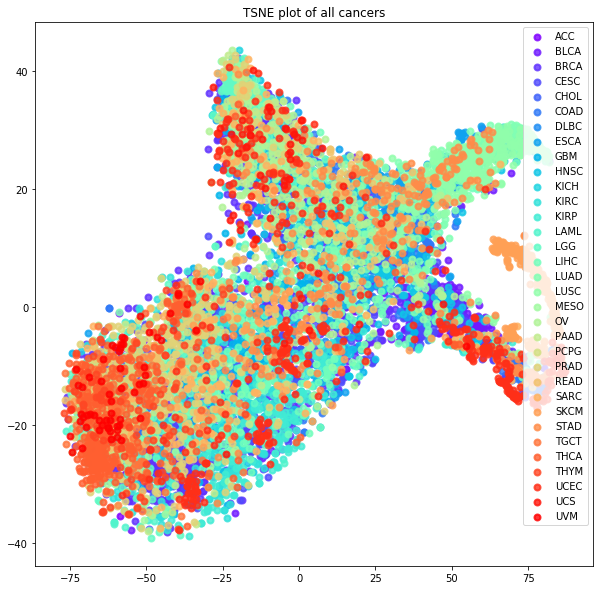

In [47]:
# perplexity=50
draw_scatterplot(new_train_data_tsne, train_labels, encoder, "TSNE plot of all cancers")

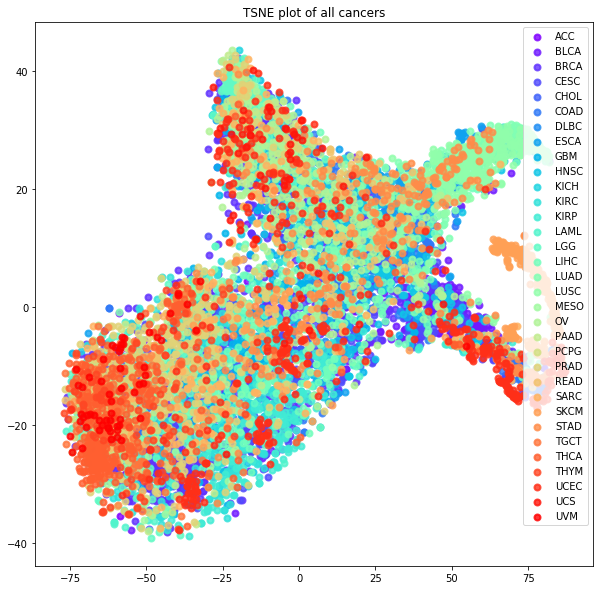

In [48]:
# perplexity=5
draw_scatterplot(new_train_data_tsne, train_labels, encoder, "TSNE plot of all cancers")

We can see above that there are micro-patterns in the overall data, but there is no clear regularity for a linear classifier to exploit. We can get a rough sense of how many different clusters there are using a GMM technique.

In [0]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=32, n_init=10, random_state=42, tol=0.01)
bgm.fit(new_train_data_pca)
np.round(bgm.weights_, 2)

## Pairwise Analysis ##

In order to ascertain if two cancers are indeed decently identifiable from each other, we switch to pairwise analysis. We are getting a sense the variation in genes is not enough to do 32-way classification with high accuracy, but we want to make sure that cancers that are getting 0 or very low precision are indeed distinguishable from other cancers with higher accuracy if they are compared pairwise.

In [0]:
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.colors import LogNorm
def gmm_analysis(train_data, train_labels):
### STUDENT START ###
    pca = PCA(n_components=2)
    X_new = pca.fit(train_data).transform(train_data)
    X_train = X_new[train_labels == 1]

    list_components = [2]
    list_covariances = ['spherical', 'diag', 'tied', 'full']

    x = np.linspace(-4., 5.)
    y = np.linspace(-4., 6.)
    A, B = np.meshgrid(x, y)
    AA = np.array([A.ravel(), B.ravel()]).T

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 16))
    
    for j, cov in enumerate(list_covariances):
        ax = axes[j]
        # fit a Gaussian Mixture Model with two components
        clf = GMM(n_components=2, covariance_type=cov)
        clf.fit(X_train)
            
        # display predicted scores by the model as a contour plot
        Z = -clf.score_samples(AA)
        Z = Z.reshape(A.shape)
            
        ax.set_xlim([-5, 6])
        ax.set_ylim([-5, 6])
        ax.title.set_text("cov = %s" %(cov))

        ax.contour(A, B, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                       levels=np.logspace(0, 3, 10))
        ax.scatter(X_train[:, 0], X_train[:, 1], .8)
        ax.axis('tight')

In [0]:
raw_test_data = pd.read_csv("./data/features_l1reg_c10.test.csv")
raw_test_data = raw_test_data.drop(columns=["Unnamed: 0", "case_id"])

In [0]:
# analyze cancer pairs
def analyze_cancer_pairs(c1, c2, visuals=False, model=True, ds=False):
    le = preprocessing.LabelEncoder()

    print("Analyzing pairwise cancers: %s and %s" %(c1, c2))
    data1 = raw_data[raw_data.cancer_type == c1]
    data2 = raw_data[raw_data.cancer_type == c2]
    print("\t%s: train count: %d" %(c1, len(data1)))
    print("\t%s: train count: %d" %(c2, len(data2)))
    rd = utils.shuffle(data1.append(data2))
    
    # downsample test samples if asked
    if ds:
        c = min(len(data1), len(data2))
        print("Downsampling training data to %d samples each" %c)
        rd = down_sample(rd, c)
        
    labels = le.fit_transform(rd.cancer_type)
    data = rd.drop(columns=['cancer_type'])

    # present visuals: PCA, TSNE & GMM
    if visuals:
        tsne = TSNE(n_components=2)
        data_tsne = tsne.fit_transform(data)
        draw_scatterplot(data_tsne, labels, le, "TSNE plot of " + c1 + " and " + c2)
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(data)
        draw_scatterplot(data_pca, labels, le, "PCA plot of " + c1 + " and " + c2)
        gmm_analysis(data, labels)
        
    # classification
    if model:
        print("Preparing the test data...")
        # prepare the test data
        tdata1 = raw_test_data[raw_test_data.cancer_type == c1]
        tdata2 = raw_test_data[raw_test_data.cancer_type == c2]
        print("\t%s: test count: %d" %(c1, len(tdata1)))
        print("\t%s: test count: %d" %(c2, len(tdata2)))
        td = utils.shuffle(tdata1.append(tdata2))
        
        # downsample test samples if asked
        if ds:
            c = min(len(tdata1), len(tdata2))
            print("Downsampling test data to %d samples each" %c)
            td = down_sample(td, c)
        
        tlabels = le.transform(td.cancer_type)
        tdata = td.drop(columns=['cancer_type'])

        # prepare and run the classifier
        cfr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                                 C=0.01, solver="liblinear", 
                                 multi_class="auto", random_state=42)
        cfr.fit(data, labels)
        pred = cfr.predict(tdata)
        # report the accuracy
        print("Accuracy: ", metrics.accuracy_score(tlabels, pred))
        print(metrics.confusion_matrix(tlabels, pred))

In [52]:
# downsample, and compare two cancers
analyze_cancer_pairs('COAD', 'BLCA', False, True, True)

Analyzing pairwise cancers: COAD and BLCA
	COAD: train count: 322
	BLCA: train count: 322
Downsampling training data to 322 samples each
(644, 14830)
Preparing the test data...
	COAD: test count: 84
	BLCA: test count: 89
Downsampling test data to 84 samples each
(168, 14830)
Accuracy:  0.9642857142857143
[[83  1]
 [ 5 79]]


This is promising. We get pretty good classification, with very few mispredicted labels when we downsample.

In [53]:
# pick a cancer that had 0 precision - ACC
analyze_cancer_pairs('ACC', 'BRCA', False, True, True)

Analyzing pairwise cancers: ACC and BRCA
	ACC: train count: 67
	BRCA: train count: 809
Downsampling training data to 67 samples each
(134, 14830)
Preparing the test data...
	ACC: test count: 25
	BRCA: test count: 211
Downsampling test data to 25 samples each
(50, 14830)
Accuracy:  0.74
[[19  6]
 [ 7 18]]


In [54]:
analyze_cancer_pairs('ACC', 'BRCA', False, True, False)

Analyzing pairwise cancers: ACC and BRCA
	ACC: train count: 67
	BRCA: train count: 809
Preparing the test data...
	ACC: test count: 25
	BRCA: test count: 211
Accuracy:  0.8940677966101694
[[  0  25]
 [  0 211]]


As expected, without downsampling, the majority class dominates.

In [55]:
analyze_cancer_pairs('UVM', 'UCS', False, True, True)

Analyzing pairwise cancers: UVM and UCS
	UVM: train count: 61
	UCS: train count: 45
Downsampling training data to 45 samples each
(90, 14830)
Preparing the test data...
	UVM: test count: 19
	UCS: test count: 12
Downsampling test data to 12 samples each
(24, 14830)
Accuracy:  1.0
[[12  0]
 [ 0 12]]


In [56]:
analyze_cancer_pairs('UVM', 'UCS', False, True, False)

Analyzing pairwise cancers: UVM and UCS
	UVM: train count: 61
	UCS: train count: 45
Preparing the test data...
	UVM: test count: 19
	UCS: test count: 12
Accuracy:  1.0
[[12  0]
 [ 0 19]]
